  

## <center>CSCI-UA 9473 Introduction to Machine Learning</center>
## <center>Assignment 3: Convolutional nets, SVM and Robust PCA</center>


<center><font color='red'><b>Given date: April 18</b></font></center>

<center><font color='red'><b>Due date: May 10</b></font></center>


#### <center>Total: 30pts</center>

Additional readings (To go further): 
 - [Robust principal component analysis? EJ Candès, X Li, Y Ma, J Wright ](https://arxiv.org/pdf/0912.3599.pdf)
 
The assignment is divided into three parts. In the first part, we will go back to neural networks. You will be asked to build and train a convolutional neural network for image classification. In the second part, 


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

import os

import numpy as np
# from numpy.linalg import svd

from fbpca import pca

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.io import loadmat
from scipy.sparse.linalg import svds

from __future__ import division

## Question I: (10pts) conv nets and autonomous driving 


In this first question, we will use [the Keras API](https://keras.io/) to build and train a convolutional neural network to discriminate between four types of road signs. To simplify we will consider the detection of 4 different signs: 

- A '30 km/h' sign (folder 1)
- A 'Stop' sign 
- A 'Go straight' sign
- A 'Keep left' sign 


<img src="learning2Drive.jpg" style="width:400px">


An example of each sign is given below.

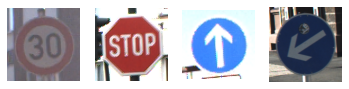

In [2]:
img1 = mpimg.imread('1/00001_00000_00012.png')
plt.subplot(141)
plt.imshow(img1)
plt.axis('off')
plt.subplot(142)
img2 = mpimg.imread('2/00014_00001_00019.png')
plt.imshow(img2)
plt.axis('off')
plt.subplot(143)
img3 = mpimg.imread('3/00035_00008_00023.png')
plt.imshow(img3)
plt.axis('off')
plt.subplot(144)
img4 = mpimg.imread('4/00039_00000_00029.png')
plt.imshow(img4)
plt.axis('off')
plt.show()

### Question I.1. (10pts) 

In this exercise, you need to build and train a convolutional neural network to discriminate between the four images.  

- Before building the network, you should start by cropping the images so that they all have a common predefined size (take the smallest size across all images) 

- We will use a __Sequential model__ from Keras but it will be up top you to define the structure of the convolution net. Initialization of the sequential model can be done with the following line 

model = Sequential()


In [3]:
# crop all images

# read all images into imgs
imgs = []

# find minimum size for all images
minImg = [100, 100]

# loop through the 4 folders finding the smallest image
for i in range(4):
    imgs.append([])
    for img in os.listdir("{}/".format(i + 1)):
        imgFile = mpimg.imread("{}/{}".format(i + 1, img))
        shape = imgFile.shape[:2]
        if shape[0] < minImg[0]:
            minImg[0] = shape[0]
        elif shape[1] < minImg[1]:
            minImg[1] = shape[1]
            
        imgs[i].append(imgFile)

imgs = np.array(imgs)

minImg

<ipython-input-3-44a2c33ce3c9>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  imgs = np.array(imgs)


[25, 25]

In [4]:
# resize
for i in range(len(imgs)): # for each classification
    for j in range(len(imgs[i])):    # each individual image
        imgs[i][j] = cv2.resize(imgs[i][j], tuple(minImg))

In [5]:
def one_hot(l, i, total):
    ones = np.ones((l, 1))
    zeros = np.zeros((l, 1))
    
    targets = ones if i == 0 else zeros
    
    for j in range(1, total):
        if i == j:
            targets = np.hstack((targets, ones))
        else:
            targets = np.hstack((targets ,zeros))
    return targets

# create classifications
targets0 = one_hot(len(imgs[0]), 0, 4)
targets1 = one_hot(len(imgs[1]), 1, 4)
targets2 = one_hot(len(imgs[2]), 2, 4)
targets3 = one_hot(len(imgs[3]), 3, 4)

targets = np.vstack((targets0, targets1, targets2, targets3))

# creates points
points = np.vstack((imgs[0], imgs[1], imgs[2], imgs[3]))
points.shape

(4500, 25, 25, 3)

#### I.1.a. Convolutions. 

- We will defintely use __convolutional layers__. you can add such layers to the model by using the lines 

        model.add(Conv2D(num_units, (filter_size1, filter_size2), padding='same',
                             input_shape=(3, IMG_SIZE, IMG_SIZE),
                             activation='relu'))
                     
for the first layer and                     

        model.add(Conv2D(filters, filter_size, activation, input_shape)

for all the others. 'filters' indicate the number of filters you want to use in the convolutional layer. filter_size is the size of each filter and activation is the usual activation that comes on top of the convolution, i.e.
$x_{\text{out}} = \sigma(\text{filter}*\text{input})$. Finally input_shape indicates the size of your input. Note that only the input layer should be given the input size. Subsequent layers will automatically compute the size of their inputs based on previous layers. 

#### I.1.b Pooling Layers 


On top of the convolutional layers, convolutional neural networks (CNN) also often rely on __Pooling layers__. The addition of such a  layer can be done through the following line 

        model.add(MaxPooling2D(pool_size=(filter_sz1, filter_sz2)))

The _pooling layers_ usually come with two parameters: the 'pool size' and the 'stride' parameter. The basic choice for the pool size is (2,2) and the stride is usually set to None (which means it will split the image into non overlapping regions such as in the Figure below). You should however feel free to play a little with those parameters. The __MaxPool operator__ considers a mask of size pool_size which is slided over the image by a number of pixels equal to the stride parameters (in x and y, there are hence two translation parameters). for each position of the mask, the output only retains the max of the pixels appearing in the mask (This idea is illustrated below). One way to understand the effect of the pooling operator is that if the filter detects an edge in a subregion of the image (thus returning at least one large value), although a MaxPooling will reduce the number of parameters, it will keep track of this information.    

Adding 'Maxpooling' layers is known to work well in practice. 

<img src="Maxpool.png" style="width:500px">


Although it is a little bit up to you to decide how you want to structure the network, a good start is to add a couple (definitely not exceeding 4) combinations (convolution, convolution, Pooling) with increasing number of units (you do every power of two like 16, 32, 128,...). 

#### I.1.c. Flattening and Fully connected layers

Once you have stacked the convolutional and pooling layers, you should flatten the output through a line of the form

        model.add(Flatten())

And add a couple (no need to put more than 2,3) dense fully connected layers through lines of the form

        model.add(Dense(num_units, activation='relu'))



#### I.1.d. Concluding 

Since there are four possible signs, you need to __finish your network with a dense layer with 4 units__. Each of those units should output four number between 0 and 1 representing the likelihood that any of the four sign is detected and such that $p_1 + p_2 + p_3 + p_4 = 1$ (hopefully with one probability much larger than the others). For this reason, a good choice for the __final activation function__ of those four units is the __softmax__ (Why?). 


Build your model below. 

In [6]:
model = Sequential()

# construct the model using convolutional layers, dense fully connected layers and 
model.add(Conv2D(16, (1, 1), padding='same',
                       input_shape=(minImg[0], minImg[1], 3),
                       activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))


model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

### Question I.2 (3pts). Setting up the optimizer

Once you found a good architecture for your network, split the dataset, by retaining about 90% of the images for training and 10% of each folder for test. To train your network in Keras, we need two more steps. The first step is to set up the optimizer. Here again it is a little bit up to you to decide how you want to set up the optimization. Two popular approaches are __SGD and ADAM__. You will get to choose the learning rate. This rate should however be between 1e-3 and 1e-2. Once you have set up the optimizer, we need to set up the optimization parameters. This includes the loss (we will take it to be the __categorical cross entropy__ which is the extension of the log loss to the multiclass problem).   

In [7]:
# split dataset
X, xTest, t, tTest = train_test_split(points, targets, test_size=0.1)

# set up the optimize here
# Myoptimizer = SGD
Myoptimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=Myoptimizer,
              metrics=['accuracy'])

### Question I.3 (2pts). Optimization

The last step is to fit the network to your data. Just as any other function in scikit-learn, we use a call to the function 'fit'. The training of neural networks can be done by splitting the dataset into minibatches and using a different batch at each SGD step. This process is repeated over the whole dataset. A complete screening of the dataset is called an epoch. We can then repeat this idea several times. In keras the number of epochs is stored in the 'epochs' parameter and the batch size is stored in the 'batch_size'.   

In [8]:
# train model
batch_size = 32
epochs = 30
model.fit(X, t,batch_size=batch_size,epochs=epochs, validation_split=0.2)

Epoch 1/30
102/102 [==============================] - 3s 20ms/step - loss: 0.8565 - accuracy: 0.6852 - val_loss: 0.1539 - val_accuracy: 0.9494
Epoch 2/30
102/102 [==============================] - 1s 12ms/step - loss: 0.1055 - accuracy: 0.9710 - val_loss: 0.0586 - val_accuracy: 0.9889
Epoch 3/30
102/102 [==============================] - 1s 9ms/step - loss: 0.0403 - accuracy: 0.9916 - val_loss: 0.0212 - val_accuracy: 0.9988
Epoch 4/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0133 - accuracy: 0.9984 - val_loss: 0.0161 - val_accuracy: 0.9988
Epoch 5/30
102/102 [==============================] - 2s 17ms/step - loss: 0.0112 - accuracy: 0.9984 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 6/30
102/102 [==============================] - 1s 9ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/30
102/102 [==============================] - 2s 18ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0027 - val_accuracy: 1.0000
E

In [9]:
# generate predictions
prediction = model.predict(xTest)

# translate from one-hot encoded
pDecoded = np.array([np.argmax(row) for row in prediction]).reshape(-1, 1)
tDecoded = np.array([np.argmax(row) for row in tTest]).reshape(-1, 1)

# calculate accuracy
accuracy_score(pDecoded, tDecoded)

0.9888888888888889

## Question II (10pts): Max margin classifiers and outliers

Consider the dataset below. We would like to learn a classifier for this dataset that maximizes the margin (i.e. such that the distance between the closest points to the plane is maximized). We have seen that one can solve this problem by means of the constrained formulation

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 \\
\text{subject to} \quad & y(\mathbf{x}^{(i)})t^{(i)} \geq 1 
\end{align*}

where $y(\mathbf{x}^{(i)}) = \mathbf{\beta}^T\mathbf{x}^{(i)} + \beta_0$. We might sometimes want to use a (softer) unconstrained formulation. in particular, when selecting this option, we can use the following function known as the _Hinge loss_ 

\begin{align*}
\max(0, 1-t^{(i)}y(\mathbf{x}^{(i)})) = \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

For such a loss, we can derive a softer, unconstrained version of the problem as 

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 + \frac{C}{N}\sum_{i=1}^N \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

In short we penalize a point, only if this point lies on the wrong side of the plane.

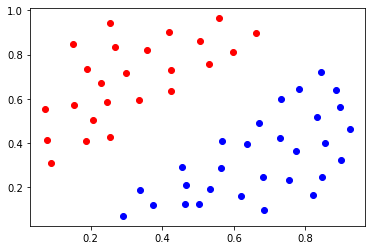

In [10]:
pointsClass1 = loadmat('KernelPointsEx4class1.mat')['PointsEx4class1']
pointsClass2 = loadmat('KernelPointsEx4class2.mat')['PointsEx4class2']


plt.scatter(pointsClass1[:,0], pointsClass1[:,1], c='r')
plt.scatter(pointsClass2[:,0], pointsClass2[:,1], c='b')
plt.show()

### Question II.1 (3pts)

Start by completing the function below which should return the value and gradient of the hinge loss at a point $\mathbf{x}^{(i)}$. What is the gradient of the hinge loss?

In [11]:
def HingeLoss(x, t, beta, beta0):
    
    '''Returns the value and gradient of the hinge 
    loss at the point x'''
    # compute value
    value = max([0], 1 - t * (np.dot(beta, x) + beta0))[0]
    
    # gradient for each component
    gradientB = (value != 0) * (-t * x)
    gradientB0 = (value != 0) * (-t)
        
    return value, [gradientB, gradientB0]
    
    

### Question II.2 (7pts)

Once you have the function, implement a function HingeLossSVC that takes as innput a starting weight vector $\mathbf{\beta}$ and intercept $\beta_0$ as well as the set of training points and a value for the parameter $C$ and returns the maximum margin classifier.  

In [12]:
def HingeLossSVC(beta_init, beta0_init, x, t, C):
    
    '''Returns the maximal margin classifier for the 
    training dataset'''
    # initialize betas
    beta = beta_init
    beta0 = beta0_init
    
    NUM_ITERS = 1000
    N = x.shape[0]
    learningRate = 0.001
    
    for i in range(NUM_ITERS):
        # loop through each point
        for j in range(N):
            # calc gradients
            gradients = HingeLoss(x[j], t[j], beta, beta0)[1]
            betaGradient = 2 / C * beta + gradients[0]
            beta0Gradient = gradients[1]
            
            # apply descent
            beta = beta - learningRate * betaGradient
            beta0 = beta0 - learningRate * beta0Gradient
            
    return beta, beta0

In [13]:
beta = np.array([0, 0])
beta0 = 0

# generate points
points = np.vstack((pointsClass1, pointsClass2))

# generate targets
targetsClass1 = np.ones((pointsClass1.shape[0], 1))
targetsClass2 = -np.ones((pointsClass2.shape[0], 1))
targets = np.vstack((targetsClass1, targetsClass2))

# predict betas
beta, beta0 = HingeLossSVC(beta, beta0, points, targets, 10000)

# beta, beta0 = HingeLossSVC(beta, beta0, points, targets, 10)
# beta, beta0

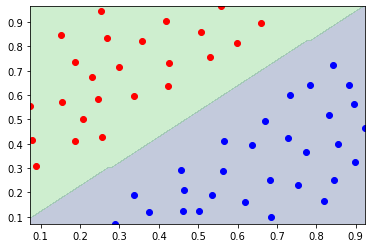

In [14]:
# generate grid
x1_min = np.min(points[:, 0])
x1_max = np.max(points[:, 0])
x2_min = np.min(points[:, 1])
x2_max = np.max(points[:, 1])
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))

# generate prediction
xPredict = np.hstack((xx1.flatten().reshape(-1, 1), xx2.flatten().reshape(-1, 1)))
prediction = np.matmul(xPredict, beta) + beta0

# plot
plt.contourf(xx1, xx2, np.reshape(prediction>0, np.shape(xx1)), levels=1, alpha=0.3)
plt.scatter(pointsClass1[:, 0], pointsClass1[:, 1], c="r")
plt.scatter(pointsClass2[:, 0], pointsClass2[:, 1], c="b")
plt.show()

## Question III (10pts): Robust PCA for video surveillance 

Principal Component Analysis (PCA) retains an approximation of an original dataset $X$ by focusing on the largest singular values. Such an order $K$ approximation can be obtained from the singular value decomposition $\boldsymbol U \boldsymbol \Sigma \boldsymbol V^T$ by truncating $\boldsymbol U$ to the first $K$ columns, retaining the $K\times K$ diagonal matrix $\boldsymbol \Sigma_k$ as well as the first $K$ rows of $\boldsymbol V^T$, $\boldsymbol V_k^T$, and writing the approximation as $\boldsymbol U_k \boldsymbol \Sigma_k \boldsymbol V^T_k$. This approach is particularly efficient when each of the feature vectors (or images in this case) are close to each other. When there is sharp variations across images, such as when an object appears, move throughout the images and then dissapears, a simple PCA does not suffice anymore and one might want to extend it to something more robust. The escalator sequence below is an example of such sequence. 

(20800,)


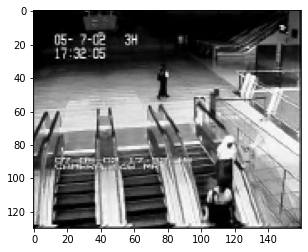

In [15]:
# read video

movie = loadmat('escalator_data.mat')
#frame0 = 
print(np.shape(movie['X'][:,0]))

plt.imshow(movie['X'][:,80].reshape((160,130)).swapaxes(0, 1), cmap='gray')
plt.show()

The idea of Robust PCA is to add a "sparse" component to the traditional PCA decomposition. Given a collection of images that we store as the columns of the matrix $X$, one then looks for a decomposition
 
\begin{align} 
\boldsymbol X = \boldsymbol Y + \boldsymbol S
\end{align}

Where $Y$ is a matrix which encode the original PCA model, and thus encodes the part of the images that remains approximately constant throughout the sequence, and $\boldsymbol S$ is the sparse part (i.e a sequence of images that are varying through the sequence but only at a precise position in the images, that is to say with most of the pixels being zero). To recover each part one approach is to proceed as follows, see [Candes et al.](https://arxiv.org/pdf/0912.3599.pdf)

We let $\mu$ to denote the parameter that controls the amount of data we want to store in the sparse foreground extraction part, $\boldsymbol S$. The algorithm proceeds as follows


__Initialize__ $Y$, $S$ to $0$

__Step 1.__ Compute the truncated SVD of the matrix $X - S - \mu^{-1}Y$, i.e. let $X - S - \mu^{-1}Y = U\Sigma V^T$. The truncated SVD is then obtained by replacing the diagonal matrix of singular values with the truncation 
$$ 
\sigma \leftarrow \text{sign}(\sigma)\max(|\sigma| - \mu, 0)  
$$

and store it in $L$, $L = SVD_{\mu}(X - S - \mu^{-1}Y)$ 



__Step 2.__ Apply the thresholding operator $f(x) = \text{sign}(x)\max(|x| - \lambda \mu, 0) $ with threshold $\lambda\mu$ to the entries of the matrix $X - L + \mu^{-1}Y$

__Step 3.__ Update the matrix $Y$ as $Y \leftarrow Y + \mu(X - L - S)$


A good approach to initialize the parameters is to take $lambda = 1/\max(m,n)$ where $\max(m,n)$ is the max number of rows or columns of the data matrix. We can then set $\mu = 0.25*(m*n)/(\sum_{i,j}|X_ij|)$. One can then terminate the algorithm when $\|X-L-S\|_F \leq  \delta \|X\|_F$ where $\|X\|_F$ is the Frobenius norm of the matrix and $\delta$ can be taken for example as $10^{-7}$. 


Additional indications: if computing the full SVD from linalg is too expensive, you can replace it with the fast randomized PCA from facebook (see [fbpca](https://fbpca.readthedocs.io/en/latest/)) or a sparse SVD.


### Question 3.1. (8pts) Complete the code below which separates the sparse part from the PCA decomposition

In [16]:

def robustPCA(X, delta=1e-6, mu=None, maxiter=500):

    '''
    The function should return a PCA like part stored in 'L' with only a few singular values 
    that are non zero and a sparse sequence 'S' in which the images are black except w very 
    limited number of pixels
    '''
    
    
    # Initialize the tuning parameters.
    lam = 1 / max(np.shape(X))
    if mu is None:   
        # complete with your value for mu
        mu = 0.25 * (X.shape[0] * X.shape[1]) / np.sum(np.abs(X.flatten())) # is this what the sum means? 
                                                                    # don't know over what j iterates
                                                                    # I'm just gonna use what the paper says it used
        
    # Convergence criterion.
    norm = np.sum(X ** 2)

    # Iterate.
    i = 0
    # HOW SHOULD I DEFINE SHAPE PLEASE HELP
    # WHAT IS A GOOD RANK?
    rank = np.min(X.shape)
    S = np.zeros(X.shape)
    Y = np.zeros(X.shape)
    while i < max(maxiter, 1):
        
        
        # Step 1. Compute and truncate the SVD
        svd_temp = X - S - (1 / mu) * Y
        U, Si, V = pca(svd_temp)
        # truncation
        Si = np.multiply(np.sign(Si), np.maximum(np.abs(Si) - mu*lam, 0))
        Si = Si * np.identity(len(Si))
        # compute L
        L = np.matmul(np.matmul(U, Si), V)
        
        

        # Step 2. Truncate the entries of X - L + mu^(-1)Y 
        S = X - L + (1 / mu) * Y
        S = np.multiply(np.sign(S), np.maximum(np.abs(S) - lam*mu, 0))
        

        # Step 3. Update the matrix Y
        Y = Y + mu * (X - L - S)
        

        # Convergence criterion
        err = np.sqrt(np.sum((X - L - S) ** 2) / norm)
        if err < delta:
            break
        i += 1

        if i >= maxiter:
            break
        
    return L, S

### Question 3.2. (2pts) 

Apply your function to the escalator sequence and display the result on at least one frame. Use subplot to display the extracted background and its corresponding foreground side by side. 

In [17]:
# put your code here

X = movie["X"]
L, S = robustPCA(X, maxiter=10000)

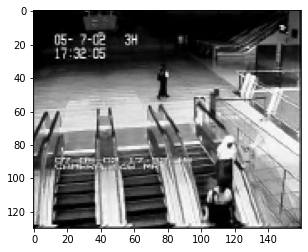

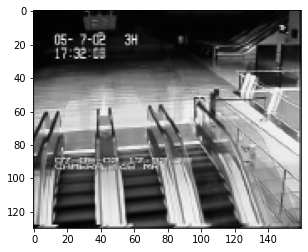

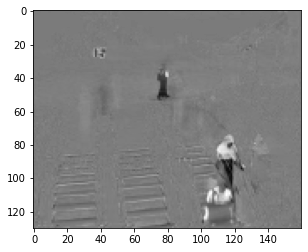

In [18]:
# original image
plt.imshow(X[:,80].reshape((160,130)).swapaxes(0, 1), cmap='gray')
plt.show()

# background extracted
plt.imshow(L[:,80].reshape((160,130)).swapaxes(0, 1), cmap='gray')
plt.show()

# foreground extracted
plt.imshow(S[:,80].reshape((160,130)).swapaxes(0, 1), cmap='gray')
plt.show()